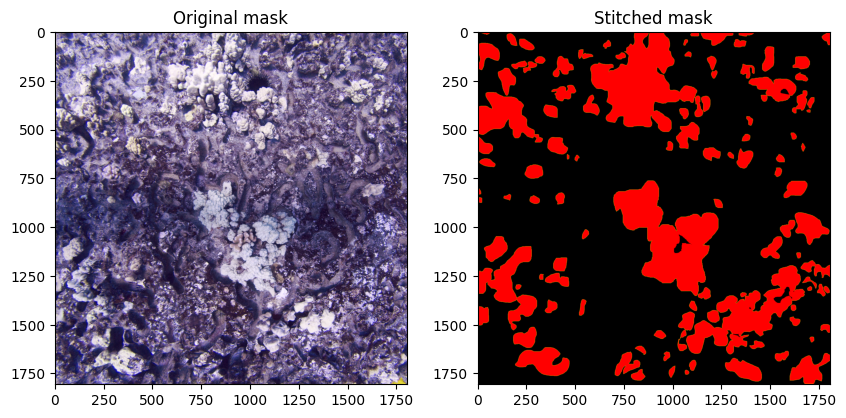

In [2]:
import matplotlib.pyplot as plt
from skimage import io
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
import pandas as pd
import numpy as np
import cv2
import imagesize
import seaborn as sns
from skimage.util import img_as_float
from skimage import io
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.morphology import disk
from scipy import ndimage as ndi
from skimage.segmentation import quickshift
import matplotlib.pyplot as plt
from skimage.segmentation import felzenszwalb
from skimage import graph


# Load the image
im_name = 38001004401

image = io.imread(fr'/Users/ansat.omurzakov/Desktop/{im_name}.jpg')
stiched_mask = io.imread(fr'/Users/ansat.omurzakov/Desktop/{im_name}_mask.png')


# Display the segmented image
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(image)
ax[0].set_title('Original mask')

ax[1].imshow(stiched_mask)
ax[1].set_title('Stitched mask')
plt.show()

In [3]:
df = pd.read_csv('annotations_PAC_USA.csv')
my_image_data = df[df['quadratid'] == 38001004401]
my_image_data

quadratid     y     x              label_name       label  \
33000  38001004401   234   250  Epilithic Algal Matrix     EAM_DHC   
33001  38001004401   331   388  Epilithic Algal Matrix     EAM_DHC   
33002  38001004401   203   110  Epilithic Algal Matrix     EAM_DHC   
33003  38001004401   384   238  Epilithic Algal Matrix     EAM_DHC   
33004  38001004401   155   324    Porites lobata/lutea    POR-MASS   
...            ...   ...   ...                     ...         ...   
33095  38001004401  1427  1222  Epilithic Algal Matrix     EAM_DHC   
33096  38001004401  1430  1551  Epilithic Algal Matrix     EAM_DHC   
33097  38001004401  1622  1486             Echinometra    MINV_Ech   
33098  38001004401  1418  1440                  Sponge  SINV_SPO_M   
33099  38001004401  1613  1538  Epilithic Algal Matrix     EAM_DHC   

                func_group  method data_set  
33000                Algae  random    train  
33001                Algae  random    train  
33002                Algae  random    train  
33003                Algae  random    train  
33004           Hard Coral  random    train  
...                    ...     ...      ...  
33095                Algae  random    train  
33096                Algae  random    train  
33097  Other Invertebrates  random    train  
33098  Other Invertebrates  random    train  
33099                Algae  random    train  

[100 rows x 8 columns]

In [8]:
# Generate superpixels using SLIC
superpixels = slic(image, n_segments=1000, compactness=10)

# Create a blank mask to hold labels
label_mask = np.zeros(superpixels.shape)

subset = my_image_data[['x', 'y', 'func_group']]
# subset['label'] = subset['func_group'].apply(lambda x: 1 if x == 'Hard Coral' else 0)÷
def func(name):
    if name.startswith('Hard'):
        return 1
    else:
        return 0
    
subset['label'] = subset['func_group'].apply(func)
subset2 = subset.drop('func_group', axis = 1)

array_data = np.array(subset2)
for x, y, label in array_data:
    superpixel_index = superpixels[x, y]
    label_mask[superpixels == superpixel_index] = label

/var/folders/9z/6v7l930d5d3fnhz8w_cp8_gw0000gn/T/ipykernel_13730/1455914631.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['label'] = subset['func_group'].apply(func)


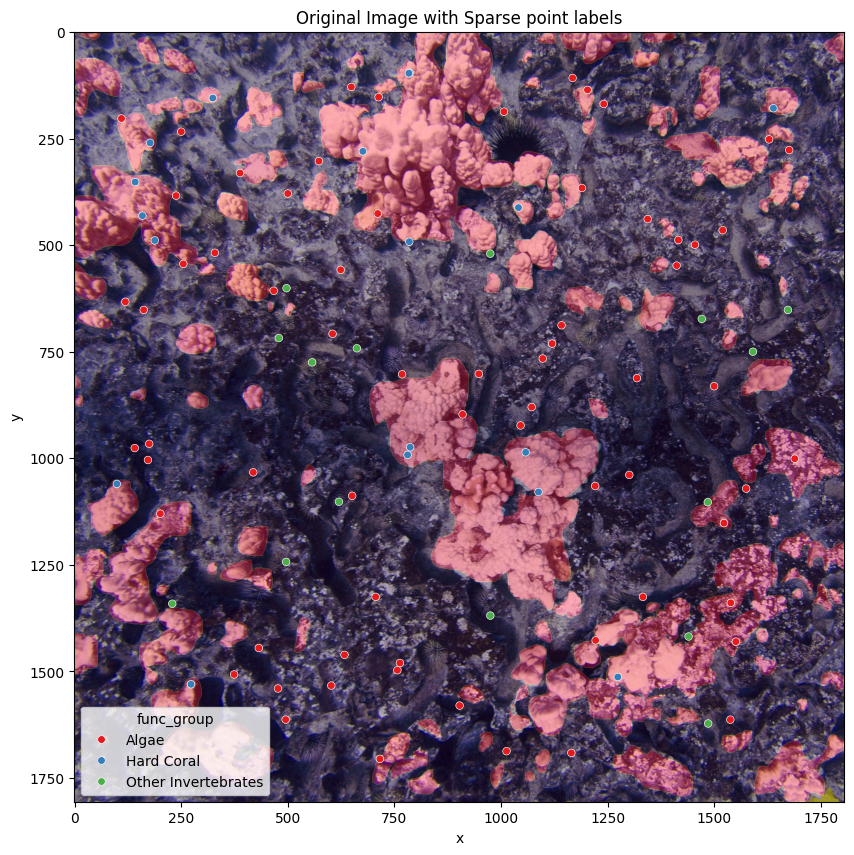

In [4]:
fig, ax = plt.subplots(figsize = (10,10))

ax.imshow(image)
sns.scatterplot(x='x', y='y', hue='func_group', data=my_image_data, ax=ax, palette='Set1', s=30)
ax.imshow(stiched_mask, alpha = 0.3)

ax.set_title('Original Image with Sparse point labels')
plt.show();

In [5]:
import cv2 as cv
import numpy as np
import os


# img = normalize(img)

def white_balance(img):
    result = cv.cvtColor(img, cv.COLOR_BGR2LAB)
    avg_a = np.average(result[:, :, 1])
    avg_b = np.average(result[:, :, 2])
    result[:, :, 1] = result[:, :, 1] - ((avg_a - 128) * (result[:, :, 0] / 255.0) * 1.1)
    result[:, :, 2] = result[:, :, 2] - ((avg_b - 128) * (result[:, :, 0] / 255.0) * 1.1)
    result = cv.cvtColor(result, cv.COLOR_LAB2BGR)
    return result

def CLAHE(img):
    R, G, B = cv.split(img)
    clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl1_R = clahe.apply(R)
    cl1_G = clahe.apply(G)
    cl1_B = clahe.apply(B)
    cl1 = cv.merge((cl1_R, cl1_G, cl1_B))
    return cl1

def normalize(img):
    img_wb = white_balance(img)
    img_wb_CLAHE = CLAHE(img_wb)
    return img_wb_CLAHE

## Superpixel methods

In [7]:
def multi_level(image, nseg_fine = 1000, compactness_fine = 10, start_label_fine=0,\
                nseg_coarse = 200, compactness_coarse =20, start_label_coarse = 0):

    image = color.rgb2lab(image)
    # Perform SLIC at multiple scales
    segments_fine = slic(image, n_segments=nseg_fine, compactness=compactness_fine, start_label=start_label_fine)
    segments_coarse = slic(image, n_segments=nseg_coarse, compactness=compactness_coarse, start_label=start_label_coarse)

    # Example of combining segments: a simple union (could be more sophisticated)
    combined_segments = np.minimum(segments_fine, segments_coarse)

    return combined_segments

def adaptive(image, num_segments_low=200, num_segments_high=1000, compactness=20):
    # Convert image to LAB color space
    lab_image = rgb2lab(image)
    
    # Compute gradient magnitude using Sobel filter
    gradient = sobel(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY))
    
    # Determine regions with high and low gradients
    mean_gradient = np.mean(gradient)
    low_gradient_mask = gradient < mean_gradient
    high_gradient_mask = gradient >= mean_gradient
    
    # Apply coarse segmentation to low-gradient regions
    low_segments = slic(image, n_segments=num_segments_low, compactness=compactness, start_label=0, mask=low_gradient_mask)
    
    # Apply fine segmentation to high-gradient regions
    high_segments = slic(image, n_segments=num_segments_high, compactness=compactness, start_label=np.max(low_segments) + 1, mask=high_gradient_mask)
    
    # Combine the two segmentations
    combined_segments = np.where(high_gradient_mask, high_segments, low_segments)
    
    return combined_segments, gradient

def seeds(img, num_superpixels=100, num_levels = 4):
    """
    Apply SEEDS superpixel segmentation using OpenCV's ximgproc.
    
    Parameters:
    img (numpy array): Input coral image in RGB format.
    num_superpixels (int): Number of superpixels.
    num_levels (int): Number of pyramid levels.
    
    Returns:
    numpy array: Superpixel segmented image.
    """

    seeds = cv2.ximgproc.createSuperpixelSEEDS(
        img.shape[1], img.shape[0], img.shape[2], num_superpixels, num_levels)

    seeds.iterate(img, 10)

    # Get the labels
    labels = seeds.getLabels()

    return labels

def lsc(img, num_superpixels = 100, compactness = 10):
    """
    Apply LSC superpixel segmentation using OpenCV's ximgproc.
    
    Parameters:
    img (numpy array): Input coral image in RGB format.
    num_superpixels (int): Number of superpixels.
    compactness (int): Compactness factor for LSC.
    
    Returns:
    numpy array: Superpixel segmented image.
    """
    lsc = cv2.ximgproc.createSuperpixelLSC(img, region_size=num_superpixels, ratio=compactness)
    lsc.iterate(10)
    
    labels = lsc.getLabels()
    
    return labels

def quickshift(img, kernel_size = 3, max_dist = 6, ratio = 0.5):
    """
    Apply Quickshift superpixel segmentation.
    
    Parameters:
    img (numpy array): Input coral image in RGB format.
    kernel_size (int): Kernel size for Quickshift.
    max_dist (int): Maximum distance between pixels.
    ratio (float): Tradeoff between color and space proximity.
    
    Returns:
    numpy array: Superpixel segmented image.
    """
    segments = quickshift(img, kernel_size = kernel_size, max_dist = max_dist, ratio = ratio)
    return segments

def watershed(img):
    """
    Apply Watershed superpixel segmentation.
    
    Parameters:
    img (numpy array): Input coral image in RGB format.
    
    Returns:
    numpy array: Superpixel segmented image.
    """

    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Compute the distance transform
    distance = ndi.distance_transform_edt(gray)
    
    # Find local maxima
    local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3, 3)))
    
    # Compute markers
    markers, _ = ndi.label(local_maxi)
    
    # Apply watershed
    segments = watershed(-distance, markers, mask=gray)
    
    return segments

def fh_ss(img, scale = 100, sigma = 0.5, min_size = 50):
    """
    Apply Felzenszwalb-Huttenlocher superpixel segmentation.
    
    Parameters:
    img (numpy array): Input coral image in RGB format.
    scale (float): Free parameter for the segmentation.
    sigma (float): Smoothing parameter for Gaussian kernel.
    min_size (int): Minimum size of components.
    
    Returns:
    numpy array: Superpixel segmented image.
    """
    segments = felzenswalb(img, scale=scale, sigma=sigma, min_size=min_size)
    return segments

def seeds_warershed(image):
    # Convert color space
    coral_img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Apply SEEDS Superpixel Segmentation
    seeds_labels = seeds(coral_img_rgb)

    # Apply Watershed Refinement
    final_segmented_img = watershed(image, seeds_labels)

    return final_segmented_img

def slic_watershed(img, num_segments=200, compactness=10):
    # Apply SLIC superpixels
    segments_slic = slic(img, n_segments=num_segments, compactness=compactness, start_label=1)

    # Create gradient image
    gray = rgb2gray(img)
    gradient = ndi.gaussian_gradient_magnitude(gray, sigma=1)

    # Apply Watershed on the SLIC segments
    markers = ndi.label(segments_slic)[0]
    labels = watershed(gradient, markers)

    # Color the boundaries in red
    segmented_img = np.copy(img)
    segmented_img[labels == -1] = [255, 0, 0]  # Boundary coloring

    return segmented_img

def graph_based_watershed(img):
    # Apply SLIC for initial superpixels
    segments = slic(img, n_segments=200, compactness=10, start_label=1)

    # Create RAG (Region Adjacency Graph)
    rag = graph.rag_mean_color(img, segments)

    # Apply Watershed
    gradient = ndi.gaussian_gradient_magnitude(rgb2gray(img), sigma=1)
    markers = ndi.label(segments)[0]
    labels = watershed(gradient, markers)

    # Color boundaries
    segmented_img = np.copy(img)
    segmented_img[labels == -1] = [255, 0, 0]  # Boundary coloring

    return segmented_img

def mean_shift_watershed(img):
    # Convert image to Lab color space
    lab_img = rgb2lab(img)

    # Use the luminance channel for thresholding
    L_channel = lab_img[:, :, 0]
    threshold = threshold_otsu(L_channel)
    markers = np.zeros_like(L_channel)
    markers[L_channel < threshold] = 1
    markers[L_channel > threshold] = 2

    # Apply Watershed algorithm
    gradient = ndi.gaussian_gradient_magnitude(rgb2gray(img), sigma=1)
    labels = watershed(gradient, markers)

    # Color boundaries
    segmented_img = np.copy(img)
    segmented_img[labels == -1] = [255, 0, 0]  # Boundary coloring

    return segmented_img

def kmeans_watershed(img, num_clusters=3):
    # Convert the image into a 2D array of pixels
    pixels = img.reshape((-1, 3))

    # Apply K-Means clustering
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(pixels)
    clustered_img = kmeans.cluster_centers_[kmeans.labels_]
    clustered_img = clustered_img.reshape(img.shape).astype(np.uint8)

    # Apply Watershed algorithm
    gradient = ndi.gaussian_gradient_magnitude(rgb2gray(clustered_img), sigma=1)
    markers = ndi.label(clustered_img[:, :, 0] > np.median(clustered_img[:, :, 0]))[0]
    labels = watershed(gradient, markers)

    # Color boundaries
    segmented_img = np.copy(img)
    segmented_img[labels == -1] = [255, 0, 0]  # Boundary coloring

    return segmented_img

def ssn_watershed(img, num_segments=100):
    # Step 1: Apply SLIC for initial superpixels
    segments_slic = slic(img, n_segments=num_segments, compactness=10, start_label=1)

    # Step 2: Use a classifier (e.g., K-Nearest Neighbors) for label propagation on superpixels
    # For simplicity, labels will be randomly assigned here (you should have predefined labels)
    knn = KNeighborsClassifier(n_neighbors=3)
    labels = np.random.randint(0, 2, size=segments_slic.shape)  # Replace this with actual labels

    # Step 3: Apply Watershed on top of SSN results
    gradient = ndi.gaussian_gradient_magnitude(rgb2gray(img), sigma=1)
    markers = ndi.label(segments_slic)[0]
    labels = watershed(gradient, markers)

    # Step 4: Color boundaries
    segmented_img = np.copy(img)
    segmented_img[labels == -1] = [255, 0, 0]  # Boundary coloring

    return segmented_img

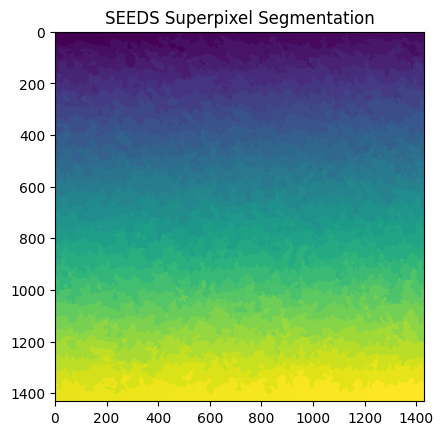

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def seeds_superpixel_segmentation(img, num_superpixels=1000, num_levels=4):
    """
    Apply SEEDS superpixel segmentation using OpenCV's ximgproc.
    
    Parameters:
    img (numpy array): Input coral image in RGB format.
    num_superpixels (int): Number of superpixels.
    num_levels (int): Number of pyramid levels.
    
    Returns:
    numpy array: Superpixel segmented image.
    """
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    seeds = cv2.ximgproc.createSuperpixelSEEDS(
        img.shape[1], img.shape[0], img.shape[2], num_superpixels, num_levels)
    
    seeds.iterate(img, 10)
    
    # Get the labels
    labels = seeds.getLabels()
    
    return labels

# Example usage
segmented_img = seeds_superpixel_segmentation(image)

plt.imshow(segmented_img)
plt.title("SEEDS Superpixel Segmentation")
plt.show()


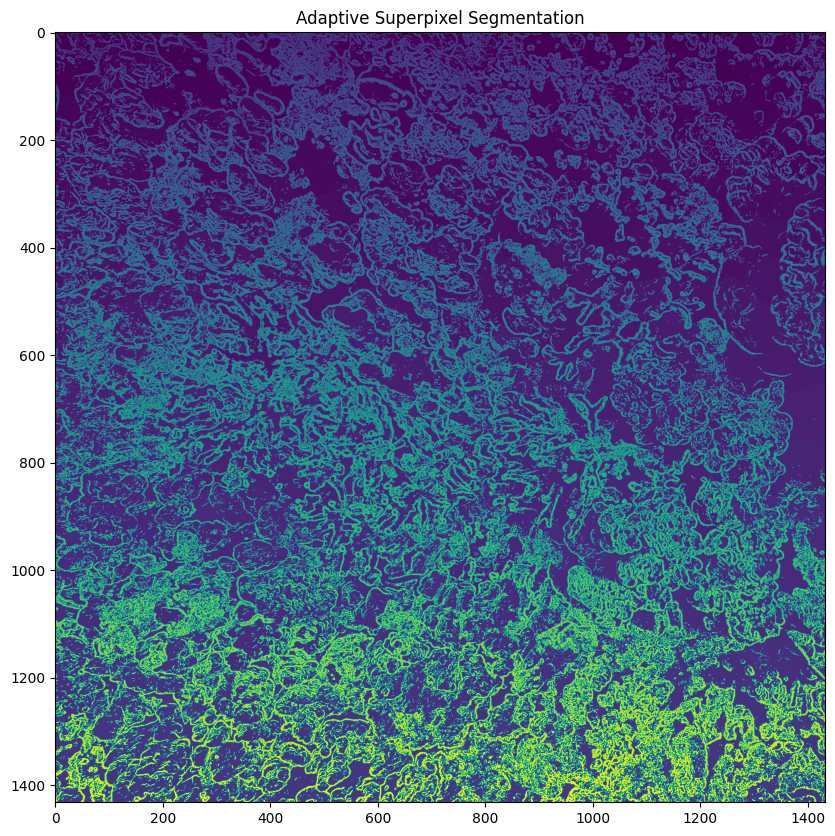

In [9]:
from skimage.segmentation import slic, mark_boundaries
from skimage.filters import sobel
from skimage.util import img_as_float
from skimage.color import rgb2gray
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread

# Load image and convert to float
img = image

# Calculate the gradient magnitude of the image (using Sobel filter)
gradient = sobel(rgb2gray(img))

# Set parameters for segmentation
num_segments_low = 200  # Coarse segmentation for flat regions
num_segments_high = 1000  # Fine segmentation for detailed regions

# Threshold to separate high-gradient and low-gradient areas
threshold = np.mean(gradient)

# Create masks for high-gradient and low-gradient regions
low_gradient_mask = gradient <= threshold
high_gradient_mask = gradient > threshold

# Apply SLIC to low-gradient regions
import numpy as np
from skimage.segmentation import slic
from skimage.color import rgb2lab
import matplotlib.pyplot as plt

# Assume img, low_gradient_mask, high_gradient_mask, num_segments_low, num_segments_high are defined

# Apply SLIC to low-gradient regions
low_segments = slic(img, n_segments=num_segments_low, compactness=20, start_label=0, mask=low_gradient_mask)

# Apply SLIC to high-gradient regions (using start_label=0 for now)
high_segments = slic(img, n_segments=num_segments_high, compactness=20, start_label=0, mask=high_gradient_mask)

# Relabel the high-gradient segments to avoid overlap with low-gradient segments
high_segments += (np.max(low_segments) + 1)

# Combine the two segmentations
adaptive_segments = np.where(high_gradient_mask, high_segments, low_segments)

# Visualize the segmentation
plt.figure(figsize=(10, 10))
plt.imshow(adaptive_segments)
plt.title('Adaptive Superpixel Segmentation')
plt.show();

In [10]:
# import numpy as np
# import matplotlib.pyplot as plt
# from skimage.segmentation import slic, mark_boundaries
# from skimage.color import rgb2lab
# from sklearn.semi_supervised import LabelSpreading
# from skimage.io import imread
# import seaborn as sns
# import matplotlib.patches as mpatches

# def get_superpixel_features(img, segments):
#     """
#     Compute the feature vector for each superpixel, including the color and centroid.
    
#     Parameters:
#     - img: Input image (numpy array).
#     - segments: Superpixel segmentation map.
    
#     Returns:
#     - features: Array of feature vectors for each superpixel.
#     - labels: Array of corresponding superpixel labels.
#     """
#     # lab_img = rgb2lab(img)  # Convert to LAB color space for perceptual similarity
#     lab_img = normalize(img)
#     num_segments = np.max(segments) + 1
    
#     features = []
#     centers = []
    
#     for segment_val in range(num_segments):
#         mask = (segments == segment_val)
        
#         # Compute the centroid of the superpixel
#         y, x = np.mean(np.argwhere(mask), axis=0)
        
#         # Compute the average LAB color within the superpixel
#         avg_color = np.median(lab_img[mask], axis=0)
        
#         # Combine color and centroid into a feature vector
#         feature_vector = np.hstack([avg_color, [y, x]])
#         features.append(feature_vector)
#         centers.append((int(y), int(x)))
    
#     return np.array(features), np.array(centers)

# # Load the image
# img = image
# # img = image

# # Parameters for SLIC (Superpixel Segmentation)
# num_segments = 1000  # You can adjust this based on the image size and detail
# compactness = 5

# # Apply SLIC to generate superpixels
# # segments = slic(img, n_segments=num_segments, compactness=compactness, start_label=0)

# # Perform SLIC at multiple scales
# # segments_fine = slic(img, n_segments=1500, compactness=10, start_label=0)
# # segments_coarse = slic(img, n_segments=200, compactness=20, start_label=0)

# # # Example of combining segments: a simple union (could be more sophisticated)
# # combined_segments = np.minimum(segments_fine, segments_coarse)

# segments = combined_segments

# # Example of sparse labeled points
# X_sparse = array_data[:, :2]
# y_sparse = array_data[:, 2]

# # Compute superpixel features (color + centroid)
# superpixel_features, superpixel_centers = get_superpixel_features(img, segments)

# # Prepare the data for Label Spreading
# num_superpixels = superpixel_centers.shape[0]
# all_points = np.vstack([X_sparse, superpixel_centers])

# # Create label array: labeled points will have their actual labels, while unlabeled points get -1
# full_labels = np.full(num_superpixels + len(y_sparse), -1)
# full_labels[:len(y_sparse)] = y_sparse  # Assign the sparse labels to the first entries

# # Use Label Spreading for propagating the labels
# label_spreading = LabelSpreading(kernel='rbf', alpha=0.8, max_iter = 100)
# label_spreading.fit(all_points, full_labels)

# # Predict labels for the superpixels
# superpixel_labels = label_spreading.transduction_[len(y_sparse):]

# # Create a mask where each superpixel is colored according to the predicted label
# label_mask = np.zeros_like(segments, dtype=np.uint8)
# for segment_val, label in zip(np.unique(segments), superpixel_labels):
#     label_mask[segments == segment_val] = label

# # Visualization: Overlay the boundaries of the superpixels
# image_with_boundaries = mark_boundaries(img, segments)

# # Create a color mapping for visualization (1 for red, 0 for blue)
# result_overlay = np.zeros((*label_mask.shape, 3), dtype=np.uint8)
# result_overlay[label_mask == 0] = [200, 0, 0]  # Red for Other
# result_overlay[label_mask == 1] = [0, 200, 0]  # Green for Hard Coral

# # Plot the original image with superpixel boundaries and overlay the classification mask
# fig, ax = plt.subplots(1, 2, figsize=(10, 10))

# ax[0].imshow(image_with_boundaries)
# ax[0].imshow(result_overlay, alpha=0.3)  # Overlay the mask with transparency
# ax[0].set_title('Superpixel Classification Result')

# ax[1].imshow(image)
# ax[1].set_title('Original Image')

# # Scatter plot of the adjusted sparse labels
# sns.scatterplot(x='x', y='y', hue='label', data=subset, ax=ax[0], palette='viridis')
# sns.scatterplot(x='x', y='y', hue='label', data=subset, ax=ax[1], palette='viridis')

# # Create custom legend patches
# legend_labels = ['Other (0)', 'Hard Coral (1)']
# legend_colors = ['red', 'green']
# patches_legend = [mpatches.Patch(color=color, label=label) for color, label in zip(legend_colors, legend_labels)]
# plt.legend(handles=patches_legend, loc='upper right', title='Function Group')

# plt.show()

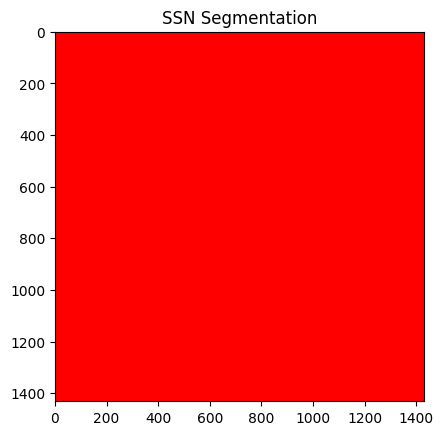

In [11]:
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from skimage.segmentation import slic
from skimage import graph
from skimage.color import rgb2lab
import matplotlib.pyplot as plt

# Superpixel Generation
def generate_superpixels(image, num_segments=500, compactness=20):
    superpixels = slic(image, n_segments=num_segments, compactness=compactness, start_label=0)
    return superpixels

# Feature Extraction
def extract_superpixel_features(image, superpixels):
    num_superpixels = np.max(superpixels) + 1
    lab_img = rgb2lab(image)
    
    # Extract mean color in LAB space for each superpixel
    features = np.zeros((num_superpixels, 3))
    for i in range(num_superpixels):
        mask = superpixels == i
        features[i] = np.mean(lab_img[mask], axis=0)
    
    return features

# Graph Construction
def build_superpixel_graph(superpixels):
    g = graph.rag_mean_color(superpixels, superpixels)
    return g

# Neural Network for Graph Propagation (basic version)
class SSNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SSNModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# SSN Label Propagation
def label_propagation(graph, features, num_classes=3):
    # Initialize SSN model
    input_dim = features.shape[1]
    hidden_dim = 64
    output_dim = num_classes
    ssn_model = SSNModel(input_dim, hidden_dim, output_dim)
    
    # Define loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(ssn_model.parameters(), lr=0.001)
    
    # Convert features to torch tensor
    features_tensor = torch.tensor(features, dtype=torch.float32)
    
    # Training loop (for simplicity, just one pass)
    for epoch in range(1):  # Normally would train for multiple epochs
        optimizer.zero_grad()
        outputs = ssn_model(features_tensor)
        
        # Fake labels (In real case, labels would come from annotated data)
        labels = torch.randint(0, num_classes, (features_tensor.shape[0],))
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    # Propagate labels using the trained model
    with torch.no_grad():
        predictions = torch.argmax(ssn_model(features_tensor), dim=1)
    
    return predictions.numpy()

# Coral Image Segmentation using SSN
def coral_segmentation_ssn(image):
    # Step 1: Generate superpixels
    superpixels = generate_superpixels(image)
    
    # Step 2: Extract features
    features = extract_superpixel_features(image, superpixels)
    
    # Step 3: Build superpixel graph
    g = build_superpixel_graph(superpixels)
    
    # Step 4: Perform label propagation with SSN
    labels = label_propagation(g, features)
    
    # Step 5: Map the labels back to the image
    segmented_img = np.zeros_like(image)
    for i in range(np.max(superpixels) + 1):
        segmented_img[superpixels == i] = np.array([255, 0, 0]) * labels[i]  # Assign color based on label
    
    return (segmented_img, superpixels, labels)

# Load your coral image
coral_img = image
coral_img_rgb = cv2.cvtColor(coral_img, cv2.COLOR_BGR2RGB)

# Perform segmentation using SSN
segmented_img, superpixel, labels = coral_segmentation_ssn(coral_img_rgb)[0], coral_segmentation_ssn(coral_img_rgb)[1], coral_segmentation_ssn(coral_img_rgb)[2]

# Display the result
plt.imshow(segmented_img)
plt.title("SSN Segmentation")
plt.show();

Epoch 0/100, Loss: 1.1106505393981934
Epoch 10/100, Loss: 1.0901700258255005
Epoch 20/100, Loss: 1.0839842557907104
Epoch 30/100, Loss: 1.0804893970489502
Epoch 40/100, Loss: 1.0718655586242676
Epoch 50/100, Loss: 1.0703189373016357
Epoch 60/100, Loss: 1.0678753852844238
Epoch 70/100, Loss: 1.0671589374542236
Epoch 80/100, Loss: 1.0703215599060059
Epoch 90/100, Loss: 1.0649850368499756


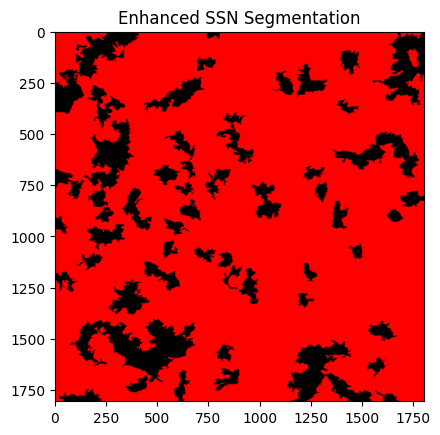

In [6]:
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from skimage.segmentation import slic
from skimage import graph
from skimage.color import rgb2lab
import matplotlib.pyplot as plt

# Superpixel Generation
def generate_superpixels(image, num_segments=1000, compactness=20):
    superpixels = slic(image, n_segments=num_segments, compactness=compactness, start_label=0)
    return superpixels

# Feature Extraction (Adding Texture and Color Features)
def extract_superpixel_features(image, superpixels):
    num_superpixels = np.max(superpixels) + 1
    lab_img = rgb2lab(image)
    
    features = np.zeros((num_superpixels, 3))  # For LAB color features
    for i in range(num_superpixels):
        mask = superpixels == i
        features[i] = np.mean(lab_img[mask], axis=0)  # Average color in LAB space

    # Optionally, you can add more feature dimensions, like texture:
    # features = np.hstack([features, texture_features])  # Combine color and texture features

    return features

# Graph Construction (Enhancing with boundary and connectivity data)
def build_superpixel_graph(image, superpixels):
    g = graph.rag_mean_color(image, superpixels)
    return g

# Improved Neural Network for SSN
class EnhancedSSNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(EnhancedSSNModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.batch_norm = nn.BatchNorm1d(hidden_dim)  # Batch Normalization Layer
        self.dropout = nn.Dropout(0.3)  # Dropout for regularization
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.batch_norm(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

# SSN Label Propagation with enhanced training and label smoothing
def label_propagation(graph, features, num_classes=3, epochs=100, learning_rate=0.001):
    input_dim = features.shape[1]
    hidden_dim = 128  # More hidden units
    output_dim = num_classes
    
    ssn_model = EnhancedSSNModel(input_dim, hidden_dim, output_dim)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # Label smoothing to prevent overconfidence
    optimizer = optim.Adam(ssn_model.parameters(), lr=learning_rate)

    # Convert features to torch tensor
    features_tensor = torch.tensor(features, dtype=torch.float32)
    
    # Dummy labels for example (replace with your ground truth labels)
    labels = torch.randint(0, num_classes, (features_tensor.shape[0],))
    
    # Training loop
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = ssn_model(features_tensor)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f'Epoch {epoch}/{epochs}, Loss: {loss.item()}')

    # Propagate labels using the trained model
    with torch.no_grad():
        predictions = torch.argmax(ssn_model(features_tensor), dim=1)

    return predictions.numpy()

# Coral Image Segmentation using SSN
def coral_segmentation_ssn(image):
    # Step 1: Generate superpixels
    superpixels = generate_superpixels(image)
    
    # Step 2: Extract features
    features = extract_superpixel_features(image, superpixels)
    
    # Step 3: Build superpixel graph
    g = build_superpixel_graph(image, superpixels)
    
    # Step 4: Perform label propagation with SSN
    labels = label_propagation(g, features)
    
    # Step 5: Map the labels back to the image
    segmented_img = np.zeros_like(image)
    for i in range(np.max(superpixels) + 1):
        segmented_img[superpixels == i] = np.array([255, 0, 0]) * labels[i]  # Assign color based on label

    return segmented_img, superpixels, labels

# Load your coral image
coral_img = normalize(image)  # Replace with actual image path
coral_img_rgb = cv2.cvtColor(coral_img, cv2.COLOR_BGR2RGB)

# Perform segmentation using SSN
segmented_img, features, labels = coral_segmentation_ssn(coral_img_rgb)

# Display the result
plt.imshow(segmented_img)
plt.title("Enhanced SSN Segmentation")
plt.show()

Text(0.5, 1.0, 'Ground Truth')

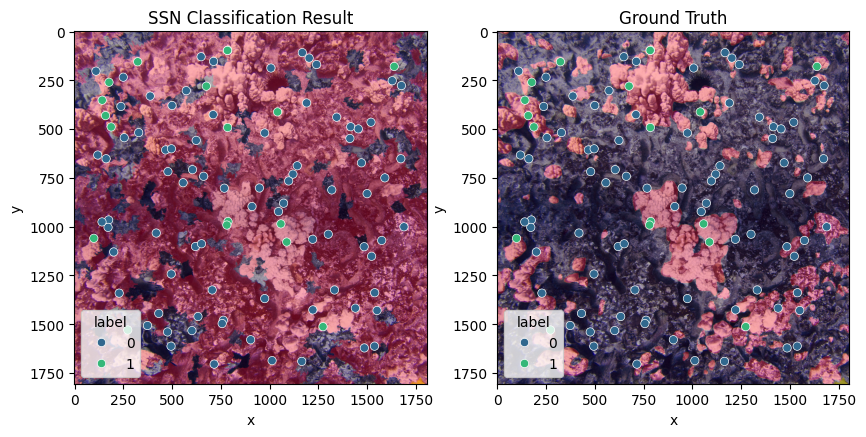

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))

ax[0].imshow(image)
ax[0].imshow(segmented_img, alpha = 0.3)
sns.scatterplot(x='x', y='y', hue='label', data=subset, ax=ax[0], palette='viridis')
ax[0].set_title('SSN Classification Result')


ax[1].imshow(image)
ax[1].imshow(stiched_mask, alpha = 0.3)
sns.scatterplot(x='x', y='y', hue='label', data=subset, ax=ax[1], palette='viridis')
ax[1].set_title('Ground Truth')

In [26]:
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from skimage.segmentation import slic
from skimage import graph
from skimage.color import rgb2lab
import matplotlib.pyplot as plt

# Superpixel Generation
def generate_superpixels(image, num_segments=500, compactness=20):
    superpixels = slic(image, n_segments=num_segments, compactness=compactness, start_label=0)
    return superpixels

# Feature Extraction (Adding Texture and Color Features)
def extract_superpixel_features(image, superpixels):
    num_superpixels = np.max(superpixels) + 1
    lab_img = rgb2lab(image)
    
    features = np.zeros((num_superpixels, 3))  # For LAB color features
    for i in range(num_superpixels):
        mask = superpixels == i
        features[i] = np.mean(lab_img[mask], axis=0)  # Average color in LAB space

    return features

# Graph Construction (Enhancing with boundary and connectivity data)
def build_superpixel_graph(image, superpixels):
    g = graph.rag_mean_color(image, superpixels)
    return g

# Improved CNN for Coral Segmentation
class CoralSegmentationNetwork(nn.Module):
    def __init__(self, num_classes):
        super(CoralSegmentationNetwork, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.dropout1 = nn.Dropout(0.5)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.dropout2 = nn.Dropout(0.5)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.dropout3 = nn.Dropout(0.5)

        self.conv4 = nn.Conv2d(256, num_classes, kernel_size=1)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.dropout2(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.dropout3(x)
        x = self.conv4(x)
        return x

# Coral Image Segmentation using CNN
def coral_segmentation_cnn(image, num_classes=3, epochs=100, learning_rate=0.001):
    # Step 1: Generate superpixels
    superpixels = generate_superpixels(image)
    
    # Step 2: Extract features
    features = extract_superpixel_features(image, superpixels)

    # Prepare dataset
    # Create a blank image for features
    height, width = image.shape[:2]
    feature_map = np.zeros((num_classes, height, width))  # Assuming num_classes is the number of segmentation classes

    # Assigning features to feature map based on superpixels
    for i in range(np.max(superpixels) + 1):
        feature_map[:, superpixels == i] = features[i]

    features_tensor = torch.tensor(feature_map, dtype=torch.float32).unsqueeze(0)  # Add batch dimension

    # Dummy labels for example (replace with your ground truth labels)
    labels = torch.randint(0, num_classes, (1, height, width))

    # Initialize the model
    model = CoralSegmentationNetwork(num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(features_tensor)  # Forward pass
        loss = criterion(outputs.view(-1, num_classes), labels.view(-1))  # Reshape for loss calculation
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        if epoch % 10 == 0:
            print(f'Epoch {epoch}/{epochs}, Loss: {loss.item()}')

    # Propagate labels using the trained model
    with torch.no_grad():
        predictions = torch.argmax(model(features_tensor), dim=1)

    # Step 5: Map the labels back to the image
    segmented_img = np.zeros_like(image)
    for i in range(np.max(superpixels) + 1):
        segmented_img[superpixels == i] = np.array([255, 0, 0]) * predictions[0, i]  # Assign color based on label

    return segmented_img, superpixels, predictions.numpy()

# Load your coral image
coral_img = image
coral_img_rgb = cv2.cvtColor(coral_img, cv2.COLOR_BGR2RGB)

# Perform segmentation using CNN
segmented_img, features, labels = coral_segmentation_cnn(coral_img_rgb)

# Display the result
plt.imshow(segmented_img)
plt.title("CNN-based Coral Segmentation")
plt.axis('off')
plt.show()


ValueError: shape mismatch: value array of shape (3,) could not be broadcast to indexing result of shape (3,23813)

In [29]:
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from skimage.segmentation import slic
from skimage import graph
from skimage.color import rgb2lab
import matplotlib.pyplot as plt

# Superpixel Generation
def generate_superpixels(image, num_segments=500, compactness=20):
    superpixels = slic(image, n_segments=num_segments, compactness=compactness, start_label=0)
    return superpixels

# Feature Extraction (Adding Texture and Color Features)
def extract_superpixel_features(image, superpixels):
    num_superpixels = np.max(superpixels) + 1
    lab_img = rgb2lab(image)
    
    features = np.zeros((num_superpixels, 3))  # For LAB color features
    for i in range(num_superpixels):
        mask = superpixels == i
        features[i] = np.mean(lab_img[mask], axis=0)  # Average color in LAB space

    return features

# Graph Construction (Enhancing with boundary and connectivity data)
def build_superpixel_graph(image, superpixels):
    g = graph.rag_mean_color(image, superpixels)
    return g

# Improved CNN for Coral Segmentation
class CoralSegmentationNetwork(nn.Module):
    def __init__(self, num_classes):
        super(CoralSegmentationNetwork, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.dropout1 = nn.Dropout(0.5)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.dropout2 = nn.Dropout(0.5)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.dropout3 = nn.Dropout(0.5)

        self.conv4 = nn.Conv2d(256, num_classes, kernel_size=1)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.dropout2(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.dropout3(x)
        x = self.conv4(x)
        return x

# Coral Image Segmentation using CNN
def coral_segmentation_cnn(image, num_classes=3, epochs=100, learning_rate=0.001):
    # Step 1: Generate superpixels
    superpixels = generate_superpixels(image)
    
    # Step 2: Extract features
    features = extract_superpixel_features(image, superpixels)

    # Prepare dataset
    # Create a blank image for features
    height, width = image.shape[:2]
    feature_map = np.zeros((3, height, width))  # Assuming num_classes is 3 for RGB output

    # Assigning features to feature map based on superpixels
    for i in range(np.max(superpixels) + 1):
        # Get the pixels corresponding to superpixel i
        mask = superpixels == i
        
        # Check if the mask has any pixels
        if np.any(mask):
            feature_map[:, mask] = features[i].reshape(-1, 1)  # Reshape to (3, 1) for broadcasting

    features_tensor = torch.tensor(feature_map, dtype=torch.float32).unsqueeze(0)  # Add batch dimension

    # Dummy labels for example (replace with your ground truth labels)
    labels = torch.randint(0, num_classes, (1, height, width))

    # Initialize the model
    model = CoralSegmentationNetwork(num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(features_tensor)  # Forward pass
        loss = criterion(outputs.view(-1, num_classes), labels.view(-1))  # Reshape for loss calculation
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        if epoch % 10 == 0:
            print(f'Epoch {epoch}/{epochs}, Loss: {loss.item()}')

    # Propagate labels using the trained model
    with torch.no_grad():
        predictions = torch.argmax(model(features_tensor), dim=1)

    # Step 5: Map the labels back to the image
    segmented_img = np.zeros_like(image)
    for i in range(np.max(superpixels) + 1):
        segmented_img[superpixels == i] = np.array([255, 0, 0]) * predictions[0, i]  # Assign color based on label

    return segmented_img, superpixels, predictions.numpy()

# Load your coral image
coral_img = image
coral_img_rgb = cv2.cvtColor(coral_img, cv2.COLOR_BGR2RGB)

# Perform segmentation using CNN
segmented_img, features, labels = coral_segmentation_cnn(coral_img_rgb)

# Display the result
plt.imshow(segmented_img)
plt.title("CNN-based Coral Segmentation")
plt.axis('off')
plt.show()


In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from Torch import CRF

class CoralSegmentationNetwork(nn.Module):
    def __init__(self, num_classes):
        super(CoralSegmentationNetwork, self).__init__()
        # Define your layers here (e.g., convolutional layers, pooling, etc.)
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc = nn.Linear(32 * (image_height // 4) * (image_width // 4), num_classes)
        
        # Define CRF
        self.crf = CRF(num_classes, batch_first=True)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)  # Flatten the feature maps
        logits = self.fc(x)  # Get the class scores
        return logits

    def apply_crf(self, logits, mask):
        """
        Apply CRF to refine segmentation mask.

        Parameters:
        logits (torch.Tensor): Output from the model (N, C)
        mask (torch.Tensor): Ground truth mask (N, H*W)

        Returns:
        torch.Tensor: Refined segmentation mask
        """
        # Decode the CRF output
        crf_output = self.crf(logits, mask)
        return crf_output


In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np
import cv2
import torch
import torch.nn.functional as F
from TorchCRF import CRF

class CoralSegmentationNetwork(nn.Module):
    def __init__(self, num_classes):
        super(CoralSegmentationNetwork, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.dropout1 = nn.Dropout(0.5)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.dropout2 = nn.Dropout(0.5)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.dropout3 = nn.Dropout(0.5)

        self.conv4 = nn.Conv2d(256, num_classes, kernel_size=1)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.dropout2(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.dropout3(x)
        x = self.conv4(x)
        return x

def label_smoothing(y_true, y_pred, smoothing=0.1):
    """Apply label smoothing to the loss."""
    num_classes = y_pred.size(1)
    one_hot = torch.zeros_like(y_pred).scatter(1, y_true.unsqueeze(1), 1)
    one_hot = one_hot * (1 - smoothing) + (smoothing / num_classes)
    return -torch.sum(one_hot * F.log_softmax(y_pred, dim=1), dim=1)

def train_model(model, dataloader, num_epochs=50, learning_rate=0.001):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.train()

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for inputs, labels in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = label_smoothing(labels, outputs)
            loss.mean().backward()
            optimizer.step()
            epoch_loss += loss.mean().item()

        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss / len(dataloader):.4f}')



# Assuming you have your model output and original image
def apply_crf_to_segmentation(model_output, original_image, num_classes):
    """
    Apply CRF to refine the segmentation mask.

    Parameters:
    model_output (torch.Tensor): The output logits from the neural network (N, C, H, W)
    original_image (torch.Tensor): The original image (N, C, H, W)
    num_classes (int): The number of segmentation classes

    Returns:
    torch.Tensor: Refined segmentation mask
    """
    
    # Convert the model output (logits) to probabilities
    probabilities = F.softmax(model_output, dim=1)

    # Initialize CRF
    crf = CRF(num_classes)

    # Reshape probabilities to (N, H*W, C) for CRF
    N, C, H, W = probabilities.shape
    probabilities_reshaped = probabilities.permute(0, 2, 3, 1).reshape(N, H * W, C)

    # Get the final CRF output
    # Note: You may want to pass additional parameters to CRF for features
    # Check your CRF's documentation on how to process inputs and get outputs
    crf_output = crf(probabilities_reshaped)  # Assuming you can call the CRF directly with probabilities

    # Reshape to (N, H, W) to get the refined segmentation mask
    refined_mask = crf_output.view(N, H, W)  # Adjust based on the output shape of your CRF

    return refined_mask


# Example usage
num_classes = 3  # Adjust as necessary
model = CoralSegmentationNetwork(num_classes)

# Assuming you have a DataLoader `dataloader` ready for training
# train_model(model, dataloader)

# After training, apply post-processing
image_np = np.expand_dims(image, axis = 0)
image_tensor = torch.tensor(image_np, dtype = torch.float32).permute(0, 3, 1, 2) 
# image_tensor = image_tensor
segmented_image = model(image_tensor)


: 

: 

In [5]:
def apply_crf_to_segmentation(model_output, original_image, num_classes):
    """
    Apply CRF to refine the segmentation mask.

    Parameters:
    model_output (torch.Tensor): The output logits from the neural network (N, C, H, W)
    original_image (torch.Tensor): The original image (N, C, H, W)
    num_classes (int): The number of segmentation classes

    Returns:
    torch.Tensor: Refined segmentation mask
    """
    
    # Convert the model output (logits) to probabilities
    probabilities = F.softmax(model_output, dim=1)

    # Initialize CRF
    crf = CRF(num_classes)

    # Reshape probabilities to (N, H * W, C) for CRF
    N, C, H, W = probabilities.shape
    probabilities_reshaped = probabilities.permute(0, 2, 3, 1).reshape(N, H * W, C)  # (N, H*W, C)

    # Prepare the labels by taking argmax over the probabilities
    labels = torch.argmax(probabilities, dim=1).view(N, H * W)  # Shape: (N, H*W)

    # Create a mask (boolean tensor)
    mask = torch.ones_like(labels, dtype=torch.bool)  # Shape: (N, H*W), dtype: bool

    # Pass the probabilities and the labels through CRF
    crf_output = crf(probabilities_reshaped, labels, mask)

    # Reshape to (N, H, W) to get the refined segmentation mask
    refined_mask = torch.argmax(crf_output, dim=1).reshape(N, H, W)

    return refined_mask


In [7]:
refined_iamge = apply_crf_to_segmentation(segmented_image, image, 3)

: 

: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5.327374..5.15308].


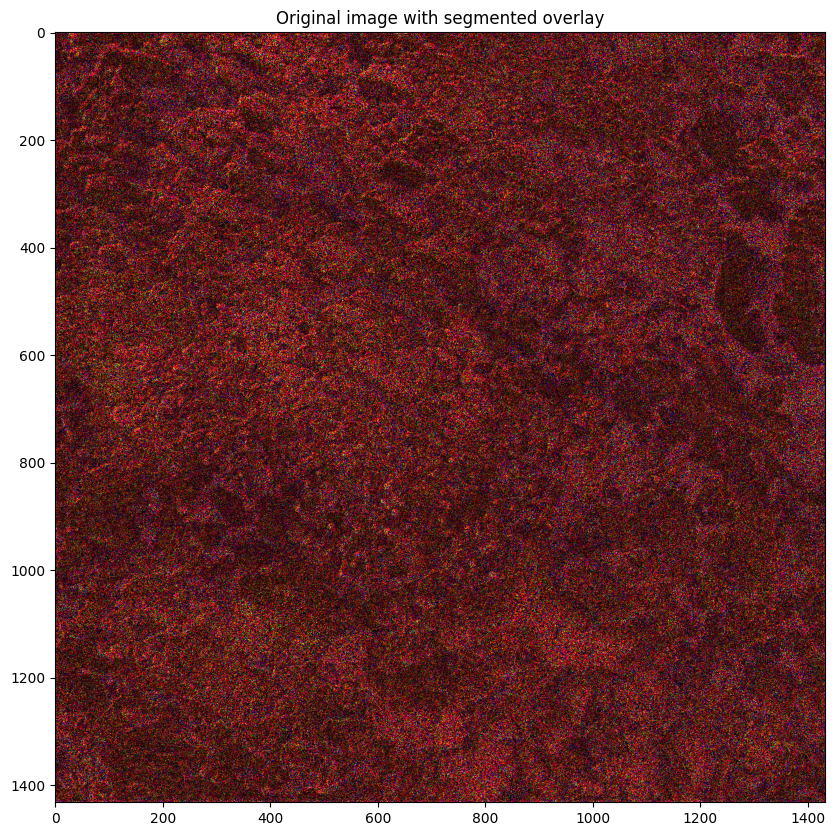

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming `image` is your original image and `segmented_image` is the output from your model.
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Display the original image
ax.imshow(image)

# Convert the segmented image to numpy and adjust its shape for imshow
# Assuming you want to visualize the first image in the batch
segmented_image_np = segmented_image.detach().numpy()[0]  # Select the first image

# Since segmented_image_np should have the shape (C, H, W), you can permute it
segmented_image_np = segmented_image_np.transpose(1, 2, 0)  # Change to (H, W, C) format

# Display the segmented image with some transparency
ax.imshow(segmented_image_np)

# If you have a subset DataFrame for scatter points
# sns.scatterplot(x='x', y='y', hue='label', data=subset, ax=ax, palette='viridis')

ax.set_title('Original image with segmented overlay')
plt.show()
